# Sheet Convolutional Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss

from SheetCNN.model import SheetCNN
from img_data.mapping import SHEET_CLASSES

## Data Augmentation

In [2]:
train_tf = transforms.Compose([
    transforms.Resize((300,300)),

    #geometric
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(300, scale=(0.7, 1.0)),

    #colors
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.02
    ),

    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

test_tf = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [3]:
path ="img_data/data"
batch = 16
raw_dataset = ImageFolder(path)

n_total = len(raw_dataset)
n_train = int(0.8 * n_total)
n_test  = n_total - n_train

train_idx, test_idx = random_split(
    range(n_total),
    [n_train, n_test]
)

train_set = ImageFolder(path, transform=train_tf)
test_set  = ImageFolder(path, transform=test_tf)

train_set = torch.utils.data.Subset(train_set, train_idx.indices)
test_set  = torch.utils.data.Subset(test_set,  test_idx.indices)

train_loader = DataLoader(train_set, batch_size=batch, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=batch, shuffle=False)

## Model

In [4]:
n_classes = len(SHEET_CLASSES.keys())
model = SheetCNN(n_classes)
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr = lr)
loss_fc = CrossEntropyLoss()

epochs = 10

In [5]:
def batch_accuracy(pred, y):
    pred_labels = pred.argmax(dim=1)
    correct = (pred_labels == y).sum().item()
    return correct / len(y)

In [6]:
history = {
    "loss": [],
    "acc": []
}

for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_acc = 0
    total_batches = 0

    for x, y in train_loader:
        optim.zero_grad()
        pred = model(x)
        loss = loss_fc(pred, y)
        loss.backward()
        optim.step()

        total_loss += loss.item()
        total_acc += batch_accuracy(pred, y)
        total_batches += 1

    epoch_loss = total_loss / total_batches
    epoch_acc  = total_acc  / total_batches

    history["loss"].append(epoch_loss)
    history["acc"].append(epoch_acc)

    print(f"Epoch {epoch}: loss={epoch_loss:.4f}  acc={epoch_acc:.4f}")


Epoch 0: loss=1.4595  acc=0.4375
Epoch 1: loss=0.9429  acc=0.6658
Epoch 2: loss=0.5593  acc=0.7989
Epoch 3: loss=0.5654  acc=0.8016
Epoch 4: loss=0.4871  acc=0.8315
Epoch 5: loss=0.3477  acc=0.8804
Epoch 6: loss=0.3833  acc=0.8913
Epoch 7: loss=0.3992  acc=0.8696
Epoch 8: loss=0.3361  acc=0.8804
Epoch 9: loss=0.2726  acc=0.9130


In [7]:
def plot_training(history):
    epochs = range(1, len(history["loss"])+1)

    plt.figure(figsize=(10,4))

    #Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history["loss"])
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    #Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history["acc"])
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

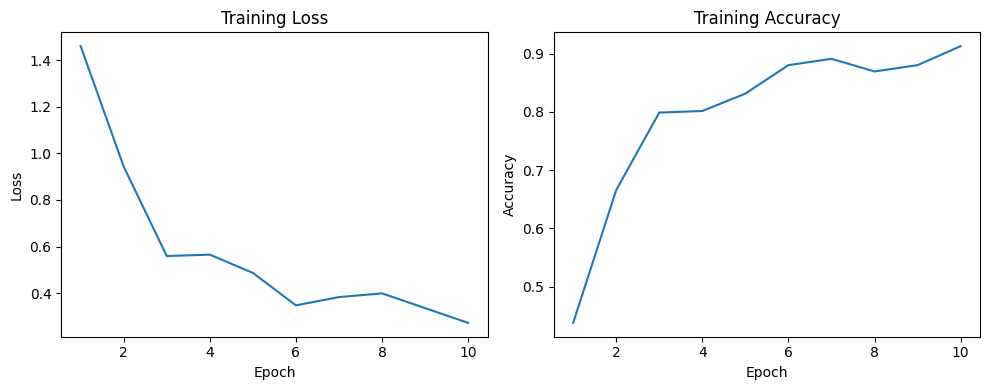

In [8]:
plot_training(history)

In [12]:
def confusion_matrix(model, loader, n_classes):
    model.eval()
    mtx = np.zeros((n_classes, n_classes), dtype=int)

    with torch.no_grad():
        for x, y in loader:
            pred = model(x).argmax(1)

            for t, p in zip(y.cpu().numpy(), pred.cpu().numpy()):
                mtx[t, p] += 1

    return mtx

In [13]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i,j], ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

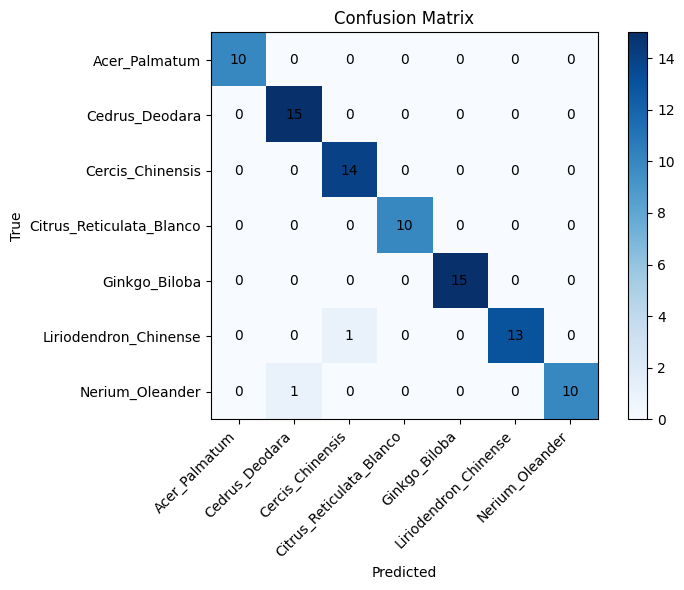

In [14]:
class_names = list(SHEET_CLASSES.keys())
cm = confusion_matrix(model, test_loader, len(class_names))
plot_confusion_matrix(cm, class_names)

In [17]:
def show_prediction(model, dataset, index, class_names):
    model.eval()

    x, true_label = dataset[index]
    x_input = x.unsqueeze(0)

    with torch.no_grad():
        pred = model(x_input).argmax(1).item()

    plt.figure(figsize=(4,4))
    plt.imshow(x.permute(1,2,0).cpu().numpy() * 0.5 + 0.5)
    plt.title(f"Predicted: {class_names[pred]}\nTrue: {class_names[true_label]}")
    plt.axis("off")
    plt.show()


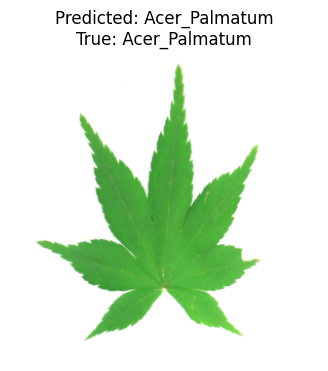

In [18]:
show_prediction(model, test_set, 10, class_names)